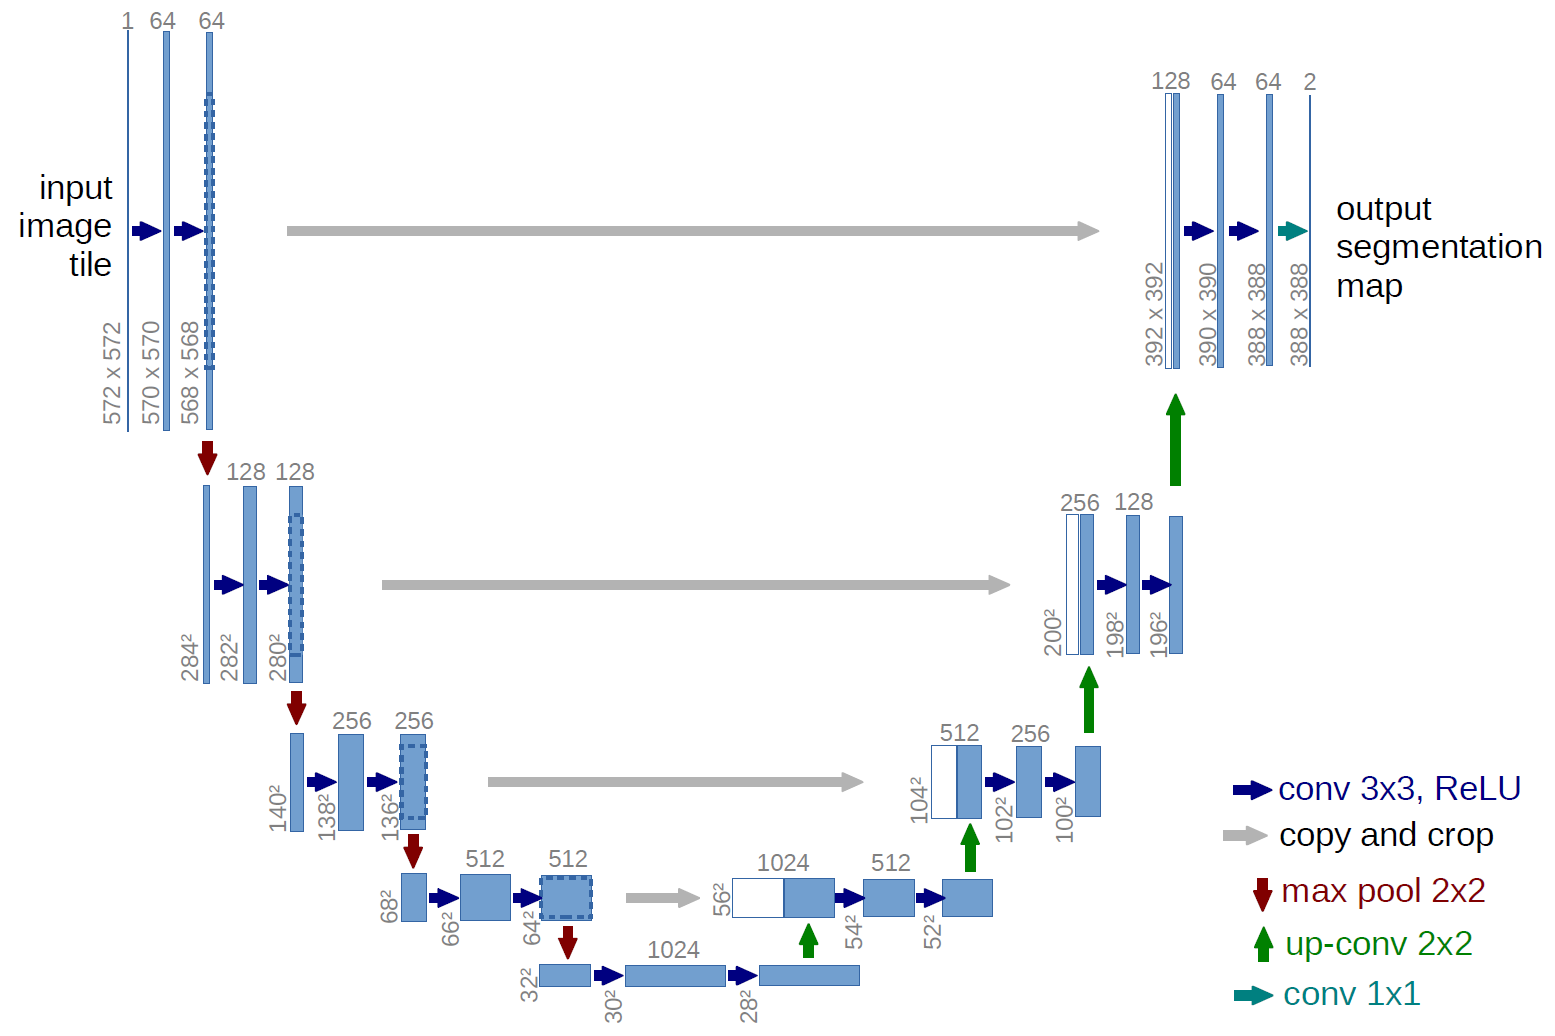


In [1]:
import torch
import torch.nn as nn
from sklearn.cluster import KMeans
import numpy as np
import torchvision.transforms as T
import matplotlib.pyplot as plt

In [2]:
def conv_block(in_channel, out_channel):
    return nn.Sequential(
        nn.Conv2d(in_channels=in_channel,
                  out_channels=out_channel, kernel_size=3,stride=1,padding=1),
        nn.BatchNorm2d(out_channel),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=out_channel,
                  out_channels=out_channel, kernel_size=3,stride=1,padding=1),
        nn.BatchNorm2d(out_channel),
        nn.ReLU(inplace=True)
    )


def up_conv_block(in_channel, out_channel):
  return nn.ConvTranspose2d(in_channels=in_channel, out_channels=out_channel, kernel_size=2,stride=2)

def copy_and_crop(left_tensor,right_tensor):
    _, _, h, w = right_tensor.shape
    crop = T.CenterCrop((h, w))(left_tensor)
    output = torch.cat((crop,right_tensor), 1)
    return output

In [3]:
class UNet(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.in_channels = in_channels
        # self.out_channels = out_channels
        self.conv1 = conv_block(self.in_channels, 64) #
        self.conv2 = conv_block(64, 128) #
        self.conv3 = conv_block(128, 256) #
        self.conv4 = conv_block(256, 512) #
        self.conv5 = conv_block(512, 1024)
        self.conv6 = up_conv_block(1024, 512)
        self.conv7 = conv_block(1024, 512)
        self.conv8 = up_conv_block(512, 256)
        self.conv9 = conv_block(512, 256)
        self.conv10 = up_conv_block(256, 128)
        self.conv11 = conv_block(256, 128)
        self.conv12 = up_conv_block(128, 64)
        self.conv13 = conv_block(128,64)
        self.conv14 = nn.Conv2d(in_channels=64,out_channels=1,kernel_size=(1,1))

    def forward(self, x):
        out1 = self.conv1(x)
        out2 = self.conv2(nn.MaxPool2d(2)(out1))
        out3 = self.conv3(nn.MaxPool2d(2)(out2))
        out4 = self.conv4(nn.MaxPool2d(2)(out3))
        out5 = self.conv5(nn.MaxPool2d(2)(out4))
        out6 = self.conv6(out5)
        out7 = self.conv7(copy_and_crop(out4, out6))
        out8 = self.conv8(out7)
        out9 = self.conv9(copy_and_crop(out3,out8))
        out10 = self.conv10(out9)
        out11 = self.conv11(copy_and_crop(out2,out10))
        out12 = self.conv12(out11)
        out13 = self.conv13(copy_and_crop(out1,out12))
        out = self.conv14(out13)
        return out

In [4]:
model=(UNet(3))

In [5]:
from PIL import Image
img=Image.open('./puppy-1903313__340.jpg')
trans=T.Compose([
    T.Resize((572,572)),
    T.ToTensor()
])
img_tensor=trans(img)
img_tensor=img_tensor.unsqueeze(0)

In [14]:
out=model(img_tensor)
out=out[:,0,:,:]>0.5

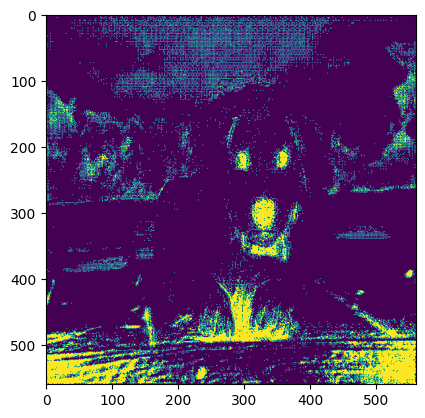

In [16]:
plt.imshow(out.squeeze(0).detach().cpu().numpy())